In [10]:
import time 
from self_pack import self_made
from self_pack import self_pointnet
import torch
s = time.time()
pointnet = main_('./normalize_txt/wall/*','./normalize_txt/test_takuya/*',1)
#torch.save(pointnet.state_dict(), './human_wall.pth')
#takuya/* と tree/*で再度モデルの作成→保存のやり直し
f = time.time()
print(f-s)


0.90920090675354


In [38]:
torch.save(pointnet.state_dict(), './human_wall.pth')

In [9]:
print('Accuracy is {} %'.format(max(Accu)))

Accuracy is 0.9375 %


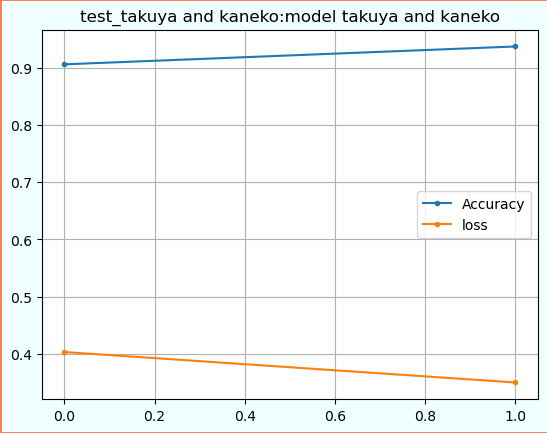

In [8]:
import matplotlib.pyplot as plt
x = range(0,len(Accu))

plt.figure(facecolor="azure", edgecolor="coral", linewidth=2)
plt.plot(x,Accu,marker='.',label='Accuracy')
plt.plot(x,loss,marker='.',label='loss')
plt.title('test_takuya and kaneko:model takuya and kaneko')
plt.grid('TRUE')
plt.legend()

In [45]:
Accu[:2]

[0.90625, 0.953125]

In [34]:
sum = 0.0
for a in Accu:
    sum = sum + a
print(sum / len(Accu))

1.0


In [37]:
a,b = data_sampler('./normalize_txt/takuya/150cm/*','./normalize_txt/tree/*')

In [26]:
import random
a = random.randint(1,10)
b = random.randint(1,10)
c = random.randint(1,10)
idx = 0
for _ in range(10):
    idx = 0
    a = random.randint(1,9)
    b = random.randint(1,9)
    c = random.randint(1,9)
    while not a == b or not b == c:
        a = random.randint(1,9)
        b = random.randint(1,9)
        c = random.randint(1,9)
        idx = idx + 1
    print('idx:{} a:{} b:{} c:{}'.format(idx,a,b,c))

idx:148 a:8 b:8 c:8
idx:17 a:6 b:6 c:6
idx:25 a:9 b:9 c:9
idx:291 a:2 b:2 c:2
idx:7 a:1 b:1 c:1
idx:1 a:9 b:9 c:9
idx:31 a:2 b:2 c:2
idx:193 a:6 b:6 c:6
idx:18 a:4 b:4 c:4
idx:7 a:8 b:8 c:8


In [21]:
9 ** 3

729